In [124]:
import numpy as np
import pandas as pd

from scipy import spatial, stats, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import plotting, input_data
from nilearn.datasets import fetch_atlas_schaefer_2018

import networkx as nx

import matplotlib.cm as mplcm
import matplotlib.colors as colors
import bct
import glob
import community as community_louvain
import matplotlib.cm as cm
from sklearn.metrics import adjusted_rand_score
import os
import random


%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [125]:
dfLabels = pd.read_csv("../resources/aal_extended.csv",header=None) 
dfLabels.columns = ['reindex','name','mark','region','side']
dfLabels["region_side"] = dfLabels["region"] + "_" + dfLabels["side"]

print(dfLabels.head())

labels = dfLabels['name'].values

   reindex               name  mark   region side region_side
0        1       Precentral_L  2001  Central    L   Central_L
1        2       Precentral_R  2002  Central    R   Central_R
2        3      Frontal_Sup_L  2101  Frontal    L   Frontal_L
3        4      Frontal_Sup_R  2102  Frontal    R   Frontal_R
4        5  Frontal_Sup_Orb_L  2111  Frontal    L   Frontal_L


In [126]:
Rand = {"N1_mean":[],
             "N2_mean":[],
             "N3_mean":[],
             "W_mean":[],
             "N1_std":[],
             "N2_std":[],
             "N3_std":[],
             "W_std":[],
             }

tipo_red="W"
sleep_states = ['N1','N2','N3']

path = r'../resources/DataSujetos' # use your path
all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

dict_rand = {}

values_obs_dict = {}

values_per_dict = {}

lists_rand = {}
for sleep_state in sleep_states:
    lists_rand[sleep_state] = []
lists_rand["W"] = []
    
for filename_W in all_files:
    #print(filename_W)
    
    df = pd.read_csv(filename_W, header=None, index_col=None,)
    thresh_cmat = (df.values > .4) * 1.0
    label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
    GW = nx.from_numpy_matrix(thresh_cmat)
    GW = nx.relabel_nodes(GW, lambda x: label_data['number'].tolist()[x])
    
    modulos = community_louvain.best_partition(GW)
    values_obs = [v for n,v in modulos.items()]
    values_obs_dict[filename_W] = values_obs
    
    #print({filename_W: set(values_obs)})
    rand_score = adjusted_rand_score(values_obs, values_obs)
    lists_rand["W"].append(rand_score)


    for sleep_state in sleep_states:
        filename_Nx = filename_W.replace("W_", sleep_state+"_")
        
        df = pd.read_csv(filename_Nx, header=None, index_col=None,)
        thresh_cmat = (df.values > .4) * 1.0
        label_data = pd.DataFrame({'number': np.arange(len(labels)) + 1, 'region_side': labels})
        GNx = nx.from_numpy_matrix(thresh_cmat)
        GNx = nx.relabel_nodes(GNx, lambda x: label_data['number'].tolist()[x])

        modulos = community_louvain.best_partition(GNx)
        values_per = [v for n,v in modulos.items()]
        values_per_dict[filename_Nx] = values_per
        #print({filename_W: set(values_obs)})

        #print({os.path.basename(filename_Nx):adjusted_rand_score(values_obs, values_per)})
        
        rand_score = adjusted_rand_score(values_obs, values_per)
        
        dict_rand[os.path.basename(filename_Nx)] = rand_score
        
        lists_rand[sleep_state].append(rand_score)
        
    #break
df_real = pd.DataFrame(lists_rand)
df_real_desc = df_real.describe()

Rand["N1_mean"].append(df_real_desc['N1']['mean'])
Rand["N2_mean"].append(df_real_desc['N2']['mean'])
Rand["N3_mean"].append(df_real_desc['N3']['mean'])
Rand["W_mean"].append(df_real_desc['W']['mean'])
Rand["N1_std"].append(df_real_desc['N1']['std'])
Rand["N2_std"].append(df_real_desc['N2']['std'])
Rand["N3_std"].append(df_real_desc['N3']['std'])
Rand["W_std"].append(df_real_desc['W']['std'])

df_rand_real = pd.DataFrame(Rand)
df_rand_real

,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std
0,0.266608,0.225363,0.166562,1.0,0.165663,0.180992,0.142386,0.0


(-0.2, 1.1)

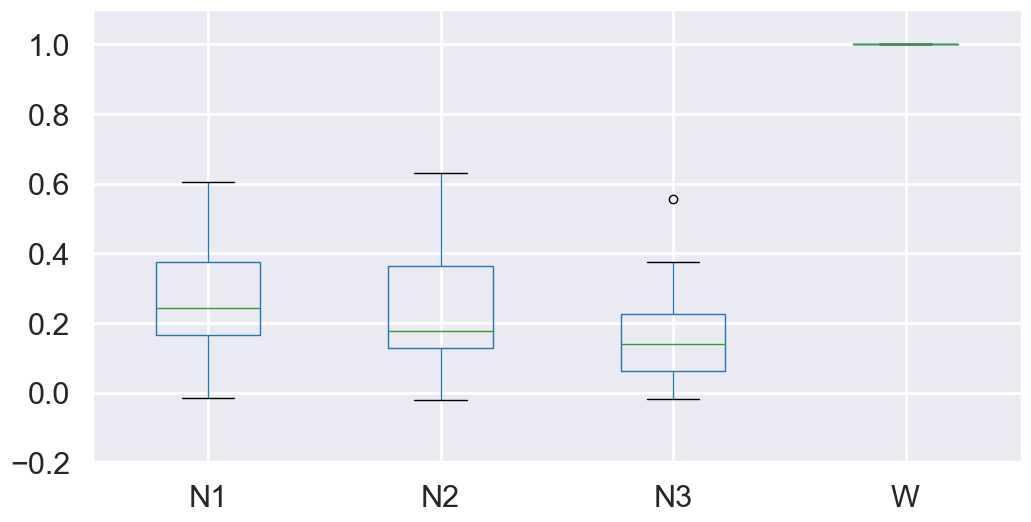

In [127]:
df_real.boxplot()
plt.ylim([-.2,1.1])

(-0.2, 1.1)

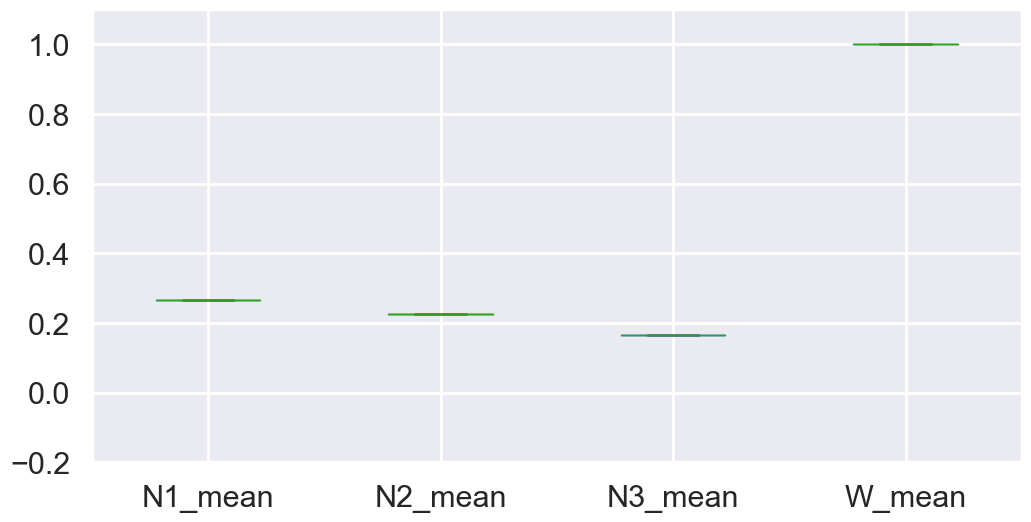

In [128]:
df_rand_real.boxplot(["N1_mean","N2_mean","N3_mean","W_mean"],)
plt.ylim([-.2,1.1])

['N1', 'N2', 'N3', 'W']
[0.26660827 0.22536339 0.16656197 1.        ]
[0.16566276 0.18099187 0.14238573 0.        ]


(-0.2, 1.1)

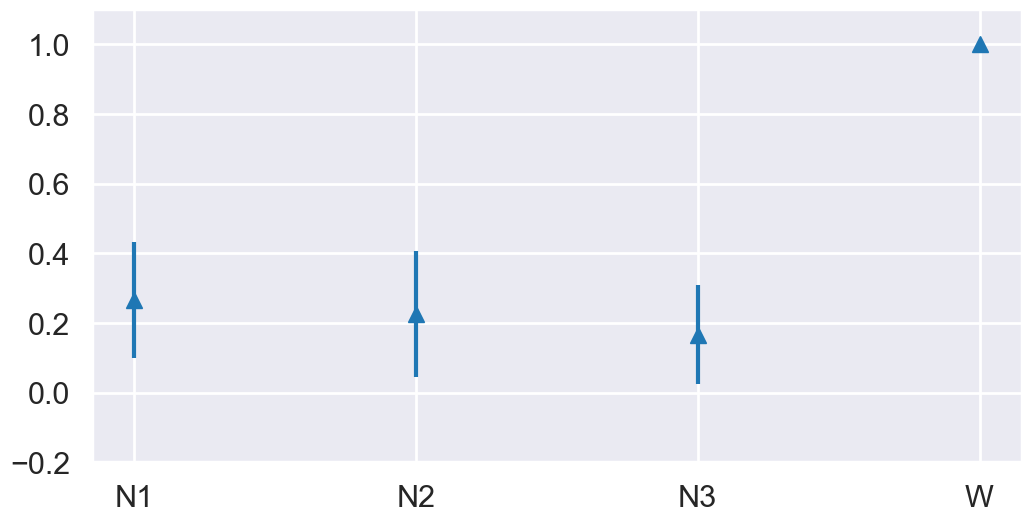

In [151]:
x = ["N1","N2","N3","W"]
y = df_rand_real[["N1_mean","N2_mean","N3_mean","W_mean"]].to_numpy()[0]
e = df_rand_real[["N1_std","N2_std","N3_std","W_std"]].to_numpy()[0]

print(x)
print(y)
print(e)

plt.errorbar(x, y, e, linestyle='None', marker='^')
plt.ylim([-.2,1.1])

In [91]:
values_per_rand = np.random.permutation(values_per_dict[filename_Nx])

In [112]:
random.seed(938413)

Np = 1000

Rand_perm = {"N1_mean":[],
             "N2_mean":[],
             "N3_mean":[],
             "W_mean":[],
             "N1_std":[],
             "N2_std":[],
             "N3_std":[],
             "W_std":[],
             }

tipo_red="W"
sleep_states = ['N1','N2','N3']

path = r'../resources/DataSujetos' # use your path
all_files = glob.glob(path + f"/{tipo_red}_suj*.csv")

for k in range(Np):

    lists_rand = {}
    for sleep_state in sleep_states:
        lists_rand[sleep_state] = []
    lists_rand["W"] = []


    for filename_W in all_files:
        values_obs = values_obs_dict[filename_W]

        values_obs_rand = np.random.permutation(values_obs_dict[filename_W])
#         values_obs_rand = list(np.random.randint(low = 0,high=4,size=len(values_obs)))
        rand_score = adjusted_rand_score(values_obs, values_obs_rand)
        lists_rand["W"].append(rand_score)

        for sleep_state in sleep_states:
            filename_Nx = filename_W.replace("W_", sleep_state+"_")
            values_per_rand = np.random.permutation(values_per_dict[filename_Nx])
#             values_per_rand = list(np.random.randint(low = 0,high=4,size=len(values_obs)))
            rand_score = adjusted_rand_score(values_obs, values_per_rand)
            lists_rand[sleep_state].append(rand_score)
        #break
    df_rand = pd.DataFrame(lists_rand)
    df_rand_desc = df_rand.describe()
    
    Rand_perm["N1_mean"].append(df_rand_desc['N1']['mean'])
    Rand_perm["N2_mean"].append(df_rand_desc['N2']['mean'])
    Rand_perm["N3_mean"].append(df_rand_desc['N3']['mean'])
    Rand_perm["W_mean"].append(df_rand_desc['W']['mean'])
    Rand_perm["N1_std"].append(df_rand_desc['N1']['std'])
    Rand_perm["N2_std"].append(df_rand_desc['N2']['std'])
    Rand_perm["N3_std"].append(df_rand_desc['N3']['std'])
    Rand_perm["W_std"].append(df_rand_desc['W']['std'])

In [113]:
df_rand_perm = pd.DataFrame(Rand_perm)
df_rand_perm

,N1_mean,N2_mean,N3_mean,W_mean,N1_std,N2_std,N3_std,W_std
0,-0.005130,0.004602,0.002854,0.000282,0.010912,0.014203,0.016072,0.012056
1,0.003539,-0.004841,0.002767,0.008612,0.017749,0.008189,0.014635,0.024079
2,-0.000827,0.001642,-0.000864,0.000308,0.017280,0.012498,0.009112,0.015168
3,-0.000749,-0.003201,0.001250,0.006107,0.010919,0.014770,0.014958,0.017664
4,0.005569,0.009433,-0.005829,0.004470,0.016560,0.017320,0.013299,0.015882
...,...,...,...,...,...,...,...,...
995,-0.001108,0.007663,-0.001052,-0.005138,0.013961,0.015621,0.008124,0.012957
996,0.004161,0.002464,0.003053,-0.000358,0.020945,0.014678,0.013961,0.009929
997,0.002082,0.001177,-0.000352,-0.005455,0.015437,0.012281,0.015447,0.014737
998,-0.000529,0.006844,-0.003622,0.002807,0.017359,0.017743,0.013169,0.015720


(-0.2, 1.1)

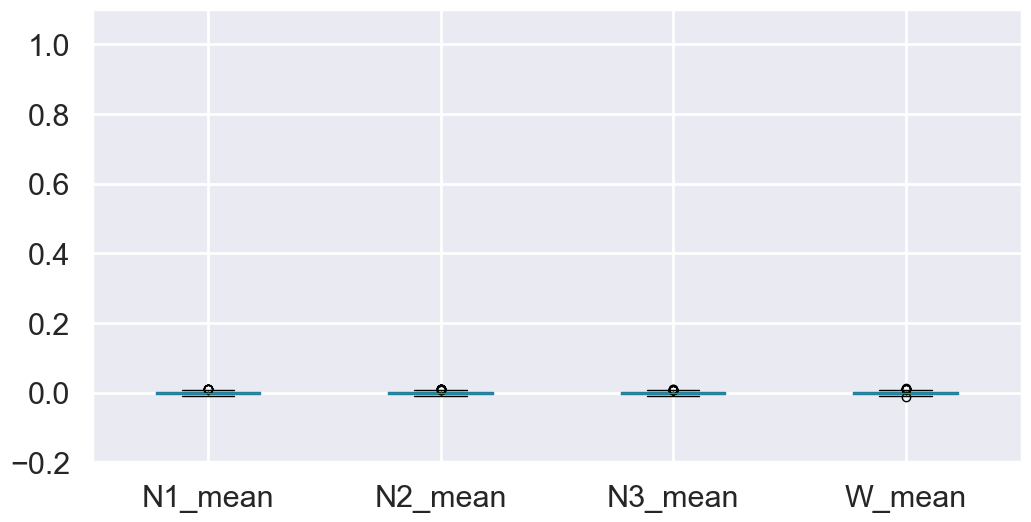

In [114]:
df_rand_perm.boxplot(["N1_mean","N2_mean","N3_mean","W_mean"])
plt.ylim([-.2,1.1])

In [115]:
sum(df_rand_perm["N1_mean"]>df_rand_real["N1_mean"][0])/Np

0.0

In [116]:
sum(df_rand_perm["N2_mean"]>df_rand_real["N2_mean"][0])/Np

0.0

In [117]:
sum(df_rand_perm["N3_mean"]>df_rand_real["N3_mean"][0])/Np

0.0

In [118]:
sum(df_rand_perm["W_mean"]>df_rand_real["W_mean"][0])/Np

0.0

In [122]:
f'Este permutation test da un p-valor << {1/Np} para todas las hipótesis.'

'Este permutation test da un p-valor << 0.001 para todas las hipótesis.'

Esto implica que el agrupamiento que se hace en el estado Nx es distinto al agrupamiento que se hace en W, y es significativamente distinto a una asignación aleatoria de etiquetas a los nodos.